In [5]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
words = open('../names.txt', 'r').read().splitlines()
print(words[:8])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32033


In [8]:
# build the vocabulary of characters and mappings to/from integers
import string
START_STOP_TOKEN = '.'
tokens = [START_STOP_TOKEN, *string.ascii_lowercase]
stoi = { s: i for i, s in enumerate(tokens) }
itos = { i: s for s, i in stoi.items() }
N_TOKENS = len(tokens)
print(itos)

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [9]:
BLOCK_SIZE = 3 # context length; number of chars used to predict the next ones
SPLIT_1 = 0.8 # 80% train
SPLIT_2 = 0.9 # 10% dev, 10% test

def build_dataset(words):
    X, Y = [], []
    for w in words:
        #print(); print(w)
        context = [0] * BLOCK_SIZE
        for ch in w + START_STOP_TOKEN:
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '-->', itos[ix])
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

# -- with train, dev, test split --
import random
random.seed(42)
shuffled_words = words[:]
random.shuffle(shuffled_words)

n1 = int(SPLIT_1 * len(shuffled_words))
n2 = int(SPLIT_2 * len(shuffled_words))

print('trainset:', end=' ')
Xtr, Ytr = build_dataset(shuffled_words[:n1])
print('devset  :', end=' ')
Xdev, Ydev = build_dataset(shuffled_words[n1:n2])
print('testset :', end=' ')
Xte, Yte = build_dataset(shuffled_words[n2:])

trainset: torch.Size([182625, 3]) torch.Size([182625])
devset  : torch.Size([22655, 3]) torch.Size([22655])
testset : torch.Size([22866, 3]) torch.Size([22866])


In [217]:
1 / (200**0.5)

0.07071067811865475

tensor(0.0014) tensor(1.0011)
tensor(6.8993e-05) tensor(1.0007)


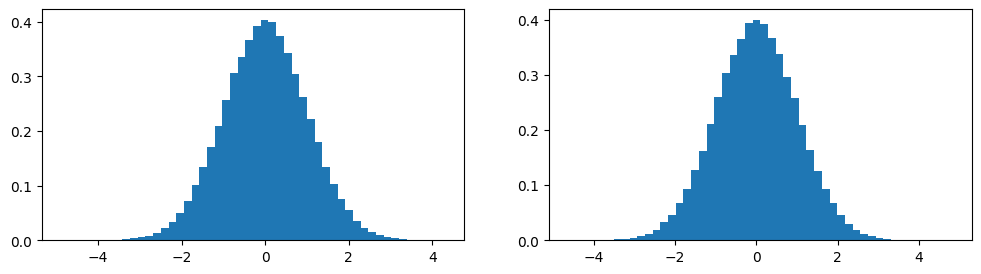

In [214]:
x = torch.randn(1000, 200)
w = torch.randn(200, 200) / (200**0.5)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [278]:
N_EMBED = 10 # dimensionality of the char embedding vectors
INPUT_SIZE = BLOCK_SIZE * N_EMBED
N_HIDDEN = 200 # number of neurons in hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
randn = lambda *size: torch.randn(size,generator=g)
kaiming_scale = lambda fan_in: (5/3)/(fan_in**0.5)

C =  randn(N_TOKENS, N_EMBED)
W1 = randn(INPUT_SIZE, N_HIDDEN)
# b1 = randn(N_HIDDEN)
W2 = randn(N_HIDDEN, N_TOKENS)
b2 = randn(N_TOKENS)

W1 *= kaiming_scale(INPUT_SIZE) # 0.2
# b1 *= 0.01
W2 *= kaiming_scale(N_HIDDEN) # 0.01
b2 *= 0

bn_gain = torch.ones((1, N_HIDDEN))
bn_bias = torch.zeros((1, N_HIDDEN))
bn_mean_running = torch.zeros((1, N_HIDDEN))
bn_std_running = torch.ones((1, N_HIDDEN))

# parameters = [C, W1,      W2, b2]
# parameters = [C, W1, b1, W2, b2, bn_gain, bn_bias]
parameters = [C, W1,     W2, b2, bn_gain, bn_bias]

for p in parameters:
    p.requires_grad = True

print('num params:', sum(p.nelement() for p in parameters))

num params: 12097


In [279]:
BATCH_SIZE = 32
MAX_STEPS = 200_000

print('Context length:', BLOCK_SIZE)
print('Number of embedding dims:', N_EMBED)
print('Batch size:', BATCH_SIZE)
print('Hidden layer size:', N_HIDDEN)
print('Number of params:', sum(p.nelement() for p in parameters))
print('-------------------------------')

lossi = []

for i in range(MAX_STEPS):
    # -- create minibactch --
    ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,), generator=g)
    x, y = Xtr[ix], Ytr[ix]

    # -- forward pass --
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    # h_preact = embcat @ W1 + b1
    h_preact = embcat @ W1
    
    # batch norm
    bn_mean_i = h_preact.mean(0, keepdim=True)
    bn_std_i = h_preact.std(0, keepdim=True)
    h_preact = bn_gain * (h_preact - bn_mean_i) / bn_std_i + bn_bias
    with torch.no_grad():
        bn_mean_running = 0.999 * bn_mean_running + 0.001 * bn_mean_i
        bn_std_running = 0.999 * bn_std_running + 0.001 * bn_std_i
    
    h = torch.tanh(h_preact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)

    # -- backward pass --
    for p in parameters:
        p.grad = None
    loss.backward()

    # -- update --
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # -- track stats --
    lossi.append(loss.log10().item())

    if i % int(MAX_STEPS / 20) == 0 or (i+1) == MAX_STEPS:
        print(f'{100*(i / MAX_STEPS):3.0f}% -- loss: {loss.item():0.4f}')

Context length: 3
Number of embedding dims: 10
Batch size: 32
Hidden layer size: 200
Number of params: 12097
-------------------------------
  0% -- loss: 4.1357
  5% -- loss: 2.0278
 10% -- loss: 2.6558
 15% -- loss: 2.0230
 20% -- loss: 2.2787
 25% -- loss: 1.8606
 30% -- loss: 2.0680
 35% -- loss: 2.3552
 40% -- loss: 2.3466
 45% -- loss: 2.1315
 50% -- loss: 2.3130
 55% -- loss: 2.2493
 60% -- loss: 1.6537
 65% -- loss: 1.9163
 70% -- loss: 2.2877
 75% -- loss: 1.9321
 80% -- loss: 2.0254
 85% -- loss: 2.3684
 90% -- loss: 2.0840
 95% -- loss: 2.0807
100% -- loss: 2.0252


torch.Size([32, 200]) torch.Size([1, 200])


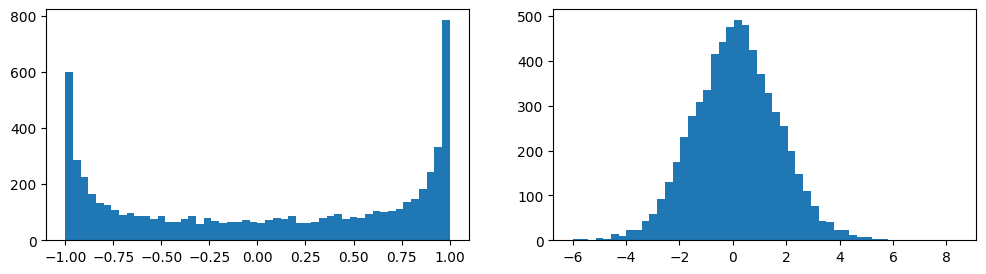

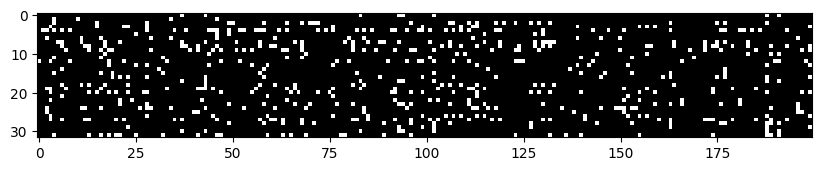

In [274]:
# For use in inspecting the initializations of the weights
print(h_preact.shape, h_preact.mean(0, keepdim=True).shape)
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.hist(h.view(-1).tolist(), 50)
plt.subplot(1, 2, 2)
plt.hist(h_preact.view(-1).tolist(), 50)
plt.show()
plt.figure(figsize=(10, 4))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

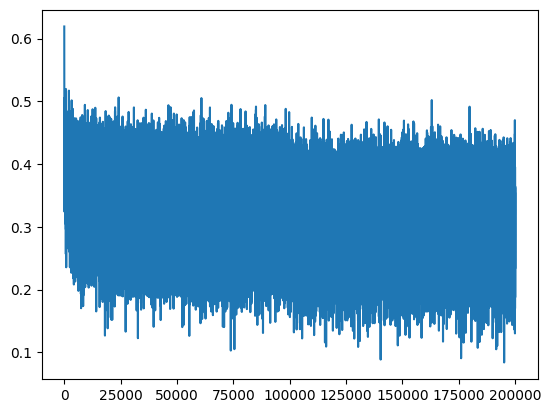

In [221]:
plt.plot(lossi)

In [280]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    h_preact = embcat @ W1 + b1
    # measure the mean / std over the entire training set
    bn_mean = h_preact.mean(0, keepdim=True)
    bn_std = h_preact.std(0, keepdim=True)

print((bn_mean - bn_mean_running).mean(), (bn_mean - bn_mean_running).std())
print((bn_std - bn_std_running).mean(), (bn_std - bn_std_running).std())

tensor(0.0010) tensor(0.0153)
tensor(0.0224) tensor(0.0088)


In [281]:
@torch.no_grad()
def print_split_loss(split):
    x, y = dict(
        train=(Xtr, Ytr),
        dev=(Xdev, Ydev),
        test=(Xte, Yte),
    )[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h_preact = embcat @ W1 + b1
    h_preact = bn_gain * (h_preact - bn_mean_running) / bn_std_running + bn_bias
    h = torch.tanh(h_preact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f'{split:5}: {loss.item():0.4f}')

print_split_loss('train')
print_split_loss('dev')

train: 2.0712
dev  : 2.1102


In [282]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * BLOCK_SIZE

    while True:
        emb = C[torch.tensor([context])] # (1, block_size, n_embed)
        embcat = emb.view(emb.shape[0], -1)
        h_preact = embcat @ W1 + b1
        h_preact = bn_gain * (h_preact - bn_mean_running) / bn_std_running + bn_bias
        h = torch.tanh(h_preact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

carmah.
amelle.
khyrmin.
reety.
salaysie.
mahnel.
delynn.
jareei.
ner.
kia.
chaiir.
kaleigh.
ham.
joce.
quinn.
salin.
alianni.
watelo.
dearyn.
kai.


In [97]:

# ------------------------
# --- pytorchification ---
# ------------------------


In [202]:
g = torch.Generator().manual_seed(2147483647)


class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) #/ fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([]  if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running "momentum update")
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch var
        else:
            xmean = self.running_mean
            xvar = self.running_var
        # normalize batch to unit variance
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update buffers
        if self.training:
            with torch.no_grad():
                m = self.momentum
                self.running_mean = (1 - m) * self.running_mean +  m * xmean
                self.running_var = (1 - m) * self.running_var +  m * xmean
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


block_size = 3
n_embed = 10
n_hidden = 100
vocab_size = len(tokens)

C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    Linear(n_embed * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden            , n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden            , n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden            , n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden            , n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden            , vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # last layer: make less confident to prevent hockey stick
    # layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1
    # apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
for p in parameters:
    p.requires_grad = True

print('number of params:', sum(p.nelement() for p in parameters))

number of params: 47551


In [203]:
BATCH_SIZE = 32
MAX_STEPS = 200_000
lossi = []
udr = []

for i in range(MAX_STEPS):
    # -- create minibatch --
    ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # -- forward pass --
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # -- backward pass --
    for layer in layers: layer.out.retain_grad() # AFTER_DEBUG: remove this
    for p in parameters:
        p.grad = None
    loss.backward()

    # -- update --
    lr = 0.1 if i < 100_000 else 0.01 # learning rate decay
    # If we drop the fan_in normalization for initializing the weights,
    #   then everything still works thanks to batch norm, but we may need
    #   to tweak the learning rate. In this case, by 10x
    lr *= 10.0
    for p in parameters:
        p.data += -lr * p.grad

    # -- track stats --
    lossi.append(loss.log10().item())
    with torch.no_grad():
        udr.append([
            (lr*p.grad.std() / p.data.std()).log10().item() for p in parameters
        ])

    if i % int(MAX_STEPS / 20) == 0 or (i+1) == MAX_STEPS:
        print(f'{100*(i / MAX_STEPS):3.0f}% -- loss: {loss.item():0.4f}')

    if i>= 1000:
        break

  0% -- loss: 3.2870


layer 2 (Tanh      ): mean +0.02, std 0.63, saturated: 3.91%
layer 5 (Tanh      ): mean -0.01, std 0.63, saturated: 3.53%
layer 8 (Tanh      ): mean -0.02, std 0.63, saturated: 3.09%
layer 11 (Tanh      ): mean -0.01, std 0.63, saturated: 2.69%
layer 14 (Tanh      ): mean +0.02, std 0.64, saturated: 3.34%


Text(0.5, 1.0, 'activation distribution')

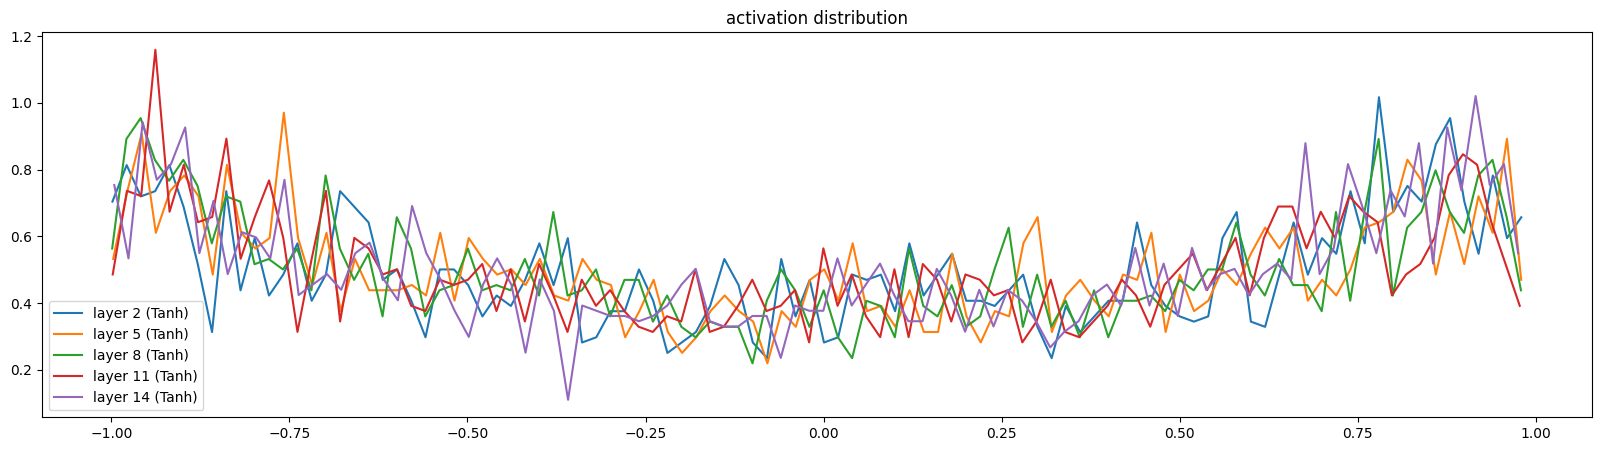

In [204]:
# visualize histograms of tanh activations
plt.figure(figsize=(20, 5))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        name = layer.__class__.__name__
        saturated = (t.abs() > 0.97).float().mean() * 100
        print(
            f'layer {i} ({name:10s}): mean {t.mean():+.2f}, std {t.std():.2f},',
            f'saturated: {saturated:.2f}%',
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({name})')
plt.legend(legends)
plt.title('activation distribution')

layer 2 (Tanh      ): mean -0.000000, std 0.004082
layer 5 (Tanh      ): mean -0.000000, std 0.003513
layer 8 (Tanh      ): mean +0.000000, std 0.003458
layer 11 (Tanh      ): mean -0.000000, std 0.003407
layer 14 (Tanh      ): mean +0.000000, std 0.003296


Text(0.5, 1.0, 'gradient distribution')

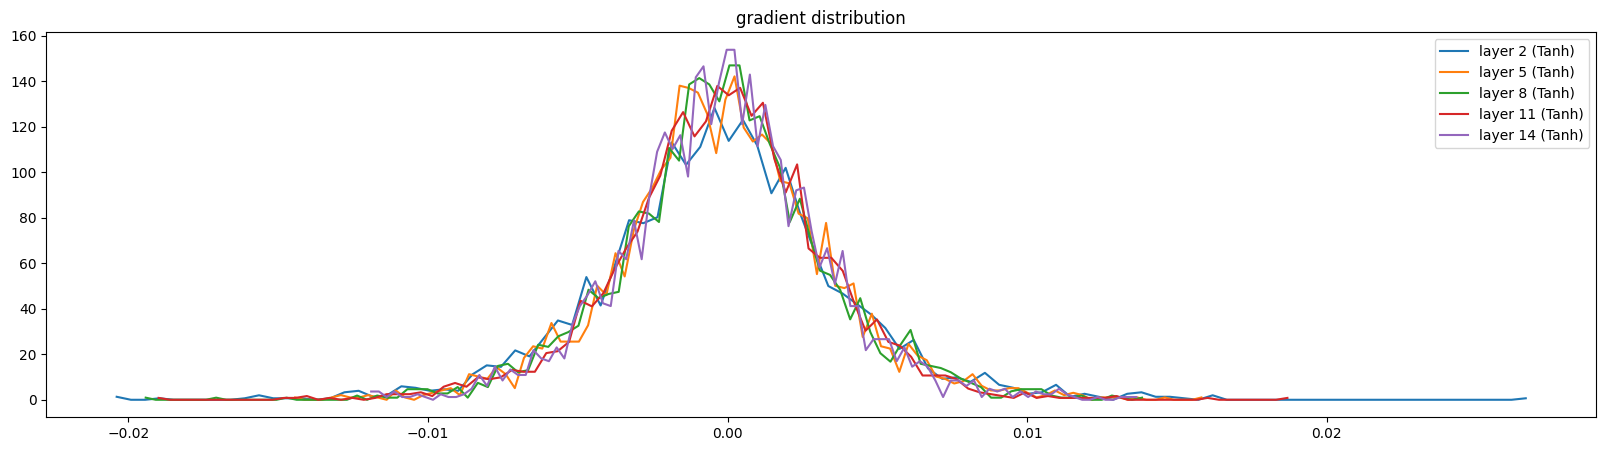

In [205]:
# visualize gradient distributions
plt.figure(figsize=(20, 5))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        name = layer.__class__.__name__
        print(f'layer {i} ({name:10s}): mean {t.mean():+f}, std {t.std():f}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({name})')
plt.legend(legends)
plt.title('gradient distribution')

weight (27, 10)   | mean +0.000000 | std 0.008340 | grad:data ratio 0.008084
weight (30, 100)  | mean +0.000061 | std 0.002610 | grad:data ratio 0.002540
weight (100, 100) | mean -0.000013 | std 0.001354 | grad:data ratio 0.001357
weight (100, 100) | mean -0.000005 | std 0.001179 | grad:data ratio 0.001170
weight (100, 100) | mean -0.000005 | std 0.001125 | grad:data ratio 0.001121
weight (100, 100) | mean +0.000006 | std 0.001151 | grad:data ratio 0.001145
weight (100, 27)  | mean -0.000025 | std 0.002196 | grad:data ratio 0.002218


Text(0.5, 1.0, 'gradient distribution')

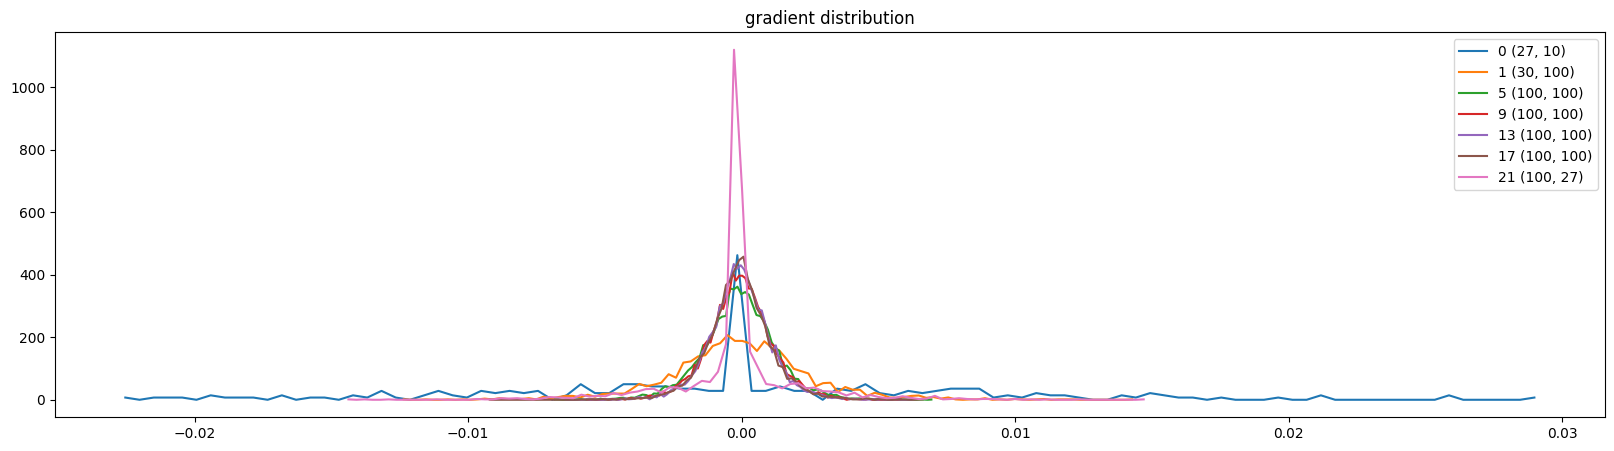

In [206]:
# visualize grad / data ratio
plt.figure(figsize=(20, 5))
legends = []
for i, p in enumerate(parameters):
    name = str(tuple(p.shape))
    t = p.grad
    if p.ndim != 2:
        continue
    print(
        f'weight {name:10s} | mean {t.mean():+f} | std {t.std():f}',
        f'| grad:data ratio {t.std() / p.std():f}',
    )
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {name}')
plt.legend(legends)
plt.title('gradient distribution')

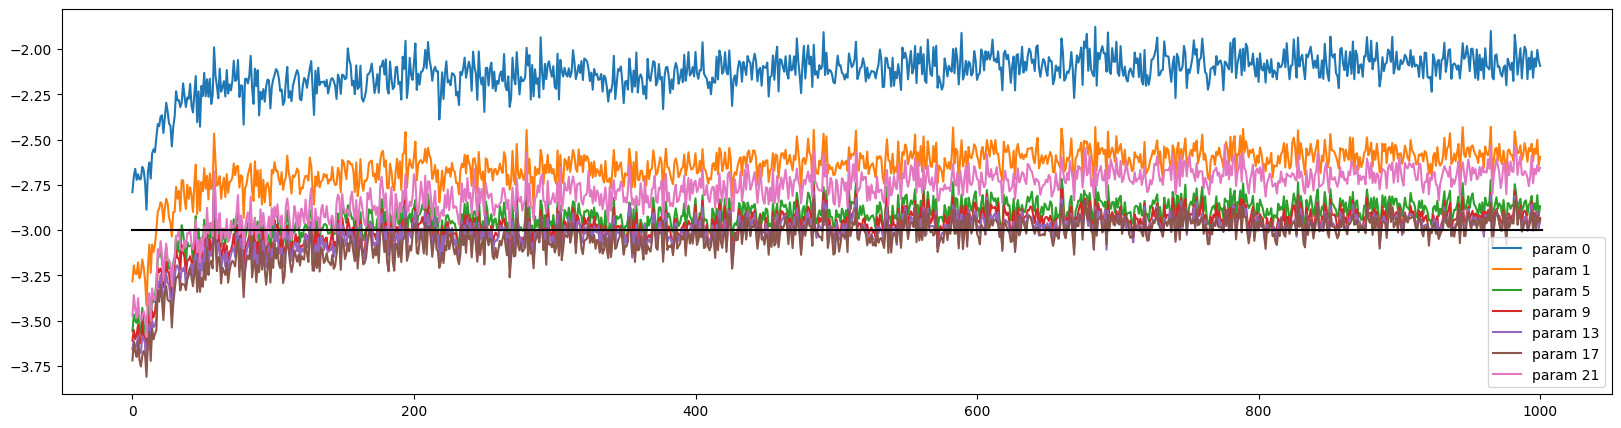

In [207]:
plt.figure(figsize=(20, 5))
legends = []
for i, p in enumerate(parameters):
    if p.ndim != 2:
        continue
    plt.plot([udr[j][i] for j in range(len(udr))])
    legends.append(f'param {i}')
plt.plot([0, len(udr)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);